# Exponentially decaying proclivity
#### $w(\delta) = w_{\rm exp}(\delta) = e^{-\delta / 2}$


## Imports and setup

In [ ]:
import sys
sys.path.append("..")

from model import *
from plttools import *

# Folders where dataset and trained model are saved
path = os.getcwd()
folder = "results_synthetic_exponential"
data_folder = os.path.join(folder,'data')
model_folder = os.path.join(folder,'model')
dataconfig_path = "../config/icassp26_synth_exp_data.jsonc"
modelconfig_path = "../config/icassp26_synth_exp_model.jsonc"

LOAD_DATA = True
LOAD_MODEL = True


### Plotting setup

In [2]:
from matplotlib import rcParams as rc
rc["font.family"] = "serif"
rc["font.size"] = 10

fw = 5
fl = 4

black = "#282828"
red = "#ee5396"
green = "#25be6a"
cyan = "#08bdba"
purple = "#78a9ff"
mauve = "#be95ff"
blue = "#33b1ff"
gray = "#dfdfe0"

clrs = {"pi":red, "d":blue, "A":cyan, "w":green, 'l':purple}
cmaps ={"pi":"viridis", "d":"cividis", "A":"plasma", "w":"inferno", "l":"magma"} 
surfs = {"pi":'summer', "d":'winter', "A":'autumn', "w":'plasma', 'l':'spring'}
line_args = { "linestyle":'-', "linewidth":3, }

num_grid = 30
num_turns = 50

clr_args = {
    "train":red,
    "val":blue,
    "test":purple,
}
bp_args = {}
bp_args['train'] = boxplot_args(clr_args["train"])
bp_args['val'] = boxplot_args(clr_args["val"])
bp_args['test'] = boxplot_args(clr_args["test"])


## Set up data

In [3]:
train_args, val_args, test_args, data_trials = load_synthdata_args_from_config(dataconfig_path)

w = lambda x: torch.exp(-.5*x) if type(x) is torch.Tensor else (np.exp(-.5*x).item() if np.isscalar(x) else np.exp(-.5*x))
train_args['w'] = w
val_args['w'] = w
test_args['w'] = w

if LOAD_DATA:
    psi_train = load_psi("psi_train", data_folder)
    pi_train = load_pi("pi_train", data_folder)
    d_train = load_d("d_train", data_folder)
    A_train = load_A("A_train", data_folder)
    convo_train = load_convo("convo_train", data_folder)
    train_data = Datasets_from_lists(psi_train, pi_train, d_train, A_train, convo_train)
    print(f"Train data loaded from folder {data_folder} | " + 
          f"No. groups: {train_data[0].num_groups} | " +
          f"No. turns: {train_data[0].num_times[0][0]}" )

    psi_val = load_psi("psi_val", data_folder)
    pi_val = load_pi("pi_val", data_folder)
    d_val = load_d("d_val", data_folder)
    A_val = load_A("A_val", data_folder)
    convo_val = load_convo("convo_val", data_folder)
    val_data = Datasets_from_lists(psi_val, pi_val, d_val, A_val, convo_val)
    print(f"Val data loaded from folder {data_folder} | " + 
          f"No. groups: {val_data[0].num_groups} | " +
          f"No. turns: {val_data[0].num_times[0][0]}" )
  
    psi_test = load_psi("psi_test", data_folder)
    pi_test = load_pi("pi_test", data_folder)
    d_test = load_d("d_test", data_folder)
    A_test = load_A("A_test", data_folder)
    convo_test = load_convo("convo_test", data_folder)
    test_data = Datasets_from_lists(psi_test, pi_test, d_test, A_test, convo_test)
    print(f"Test data loaded from folder {data_folder} | " + 
          f"No. groups: {test_data[0].num_groups} | " +
          f"No. turns: {test_data[0].num_times[0][0]}" )
else:
    train_data = []; val_data = []; test_data = []
    for dt in range(data_trials):
        print(f"Generating data trial {dt+1}/{data_trials}")
        train_data.append(generate_dataset(**train_args))
        val_data.append(generate_dataset(**val_args))
        test_data.append(generate_dataset(**test_args))
        
    os.makedirs(data_folder, exist_ok=True)
    save_dataset_list(train_data, filetag="_train", path=data_folder)
    save_dataset_list(val_data, filetag="_val", path=data_folder)
    save_dataset_list(test_data, filetag="_test", path=data_folder)
    print(f"Data saved to folder {data_folder}")



Train data loaded from folder results_icassp26_synth_exp_2025-09-07-1218/data | No. groups: 10 | No. turns: 800
Val data loaded from folder results_icassp26_synth_exp_2025-09-07-1218/data | No. groups: 5 | No. turns: 800
Test data loaded from folder results_icassp26_synth_exp_2025-09-07-1218/data | No. groups: 5 | No. turns: 800


## Baselines

Potential baselines include training a model or comparing model output when using the same traits for all speakers or randomized version of the same traits.

In [4]:
num_feat = test_data[0].num_feat
psis_same = [[list(torch.ones((test_data[dt].num_speakers[g], num_feat))) for g in range(test_data[dt].num_groups)] for dt in range(data_trials)]
shuffled_indices = [[np.random.permutation(test_data[dt].num_speakers[g]) for g in range(test_data[dt].num_groups)] for dt in range(data_trials)]
psis_rand = [[[test_data[dt].psi[g][s] for s in shuffled_indices[dt][g]] for g in range(test_data[dt].num_groups)] for dt in range(data_trials)]

pis = [test_data[dt].pi for dt in range(data_trials)]
ds = [test_data[dt].d for dt in range(data_trials)]
As = [test_data[dt].A for dt in range(data_trials)]
convos = [test_data[dt].convos for dt in range(data_trials)]

print("Same traits")
same_test_data = Datasets_from_lists(psis_same, pis, ds, As, convos)
print("Randomized traits")
rand_test_data = Datasets_from_lists(psis_rand, pis, ds, As, convos)


Same traits
Randomized traits


## Set up model

In [5]:
model_config = load_model_params_from_config(modelconfig_path)
model_trials = model_config['model_trials']
model_args = model_config['MODEL']
models = [[GRACIEModel(**model_args) for mt in range(model_trials)] for dt in range(data_trials)]


## Train model

Models loaded from results_icassp26_synth_exp_2025-09-07-1218/model


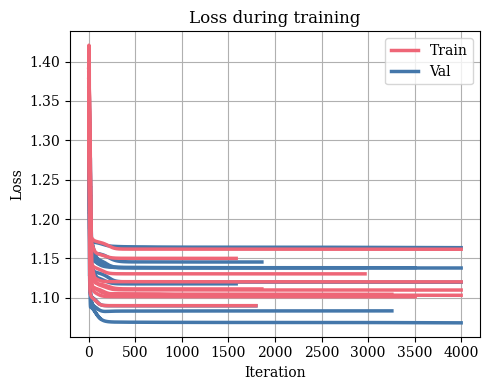

In [6]:
if LOAD_MODEL:
    models = load_trained_models_list(models,model_folder)
    models = load_model_results_list(models,model_folder)
    print(f"Models loaded from {model_folder}")
else:
    for dt in range(data_trials):
        for mt in range(model_trials):
            print(f"Data trial: {dt+1}/{data_trials} | Model trial: {mt+1}/{model_trials}")

            tic = perf_counter()
            models[dt][mt].train(train_data[dt], val_data[dt], test_data[dt])
            toc = perf_counter()
            ellapsed = toc-tic
            msg = f"{ellapsed:.1f}s" if ellapsed<60 else (f"{ellapsed//60}m {ellapsed%60:.1f}s" if ellapsed<3600 else f"{ellapsed//3600}h {(ellapsed%3600)//60}m {ellapsed%60:.2f}s")
            print(f"Time ellapsed: {msg}")
            print(f"Train loss: {models[dt][mt].loss_train_pred:.3f} | " +
                f"Val loss: {models[dt][mt].loss_val_pred:.3f} | " + 
                f"Test loss: {models[dt][mt].loss_test_pred:.3f}" )
            print("")

    print(f"Saving experiment")
    os.makedirs(model_folder, exist_ok=True)
    save_trained_models_list(models,model_folder)
    save_model_results_list(models,model_folder)
    print(f"Models saved to folder `{model_folder}`")
    print("")

fig,ax = plt.subplots(figsize=(5,4)); ax.grid(1); ax.set_axisbelow(1)
for dt in range(data_trials):
    for mt in range(model_trials):
        pt, = ax.plot(models[dt][mt].loss_train_list,'-',c=bq['red'], linewidth=2.5, label="Train", zorder=3)
        pv, = ax.plot(models[dt][mt].loss_val_list,'-',c=bq['blue'], linewidth=2.5, label="Val", zorder=1)
ax.set_xlabel("Iteration"); ax.set_ylabel("Loss"); ax.legend(handles=[pt,pv])
ax.set_title(f"Loss during training")
fig.tight_layout()


## Visualize results

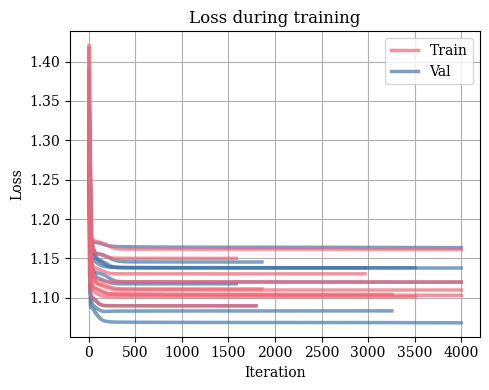

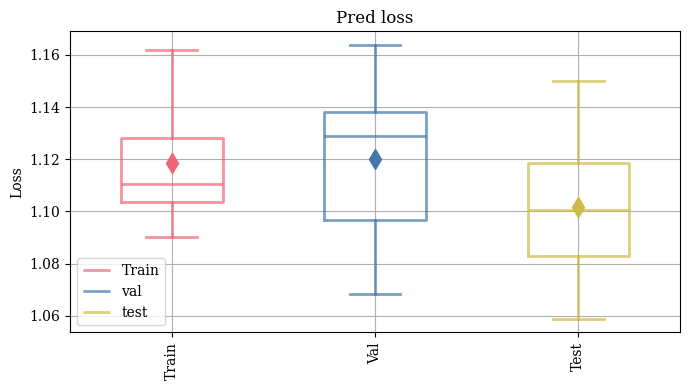

In [12]:
train_loss_pred = [models[dt][mt].loss_train_pred for dt in range(data_trials) for mt in range(model_trials)]
val_loss_pred = [models[dt][mt].loss_val_pred for dt in range(data_trials) for mt in range(model_trials)]
test_loss_pred = [models[dt][mt].loss_test_pred for dt in range(data_trials) for mt in range(model_trials)]

clrs = {"pi":bq['red'], "d":bq['blue'], "A":bq['yellow'], "w":bq["green"], 'l':bq['purple']}
clrs_pred = {"pi":lq['orange'], "d":lq['blue'], "A":lq['yellow'], "w":lq["pear"], 'l':lq['pink']}
cmaps ={"pi":"viridis", "d":"cividis", "A":"plasma", "w":"inferno", "l":"magma"} 
surfs = {"pi":'summer', "d":'winter', "A":'autumn', "w":'plasma', 'l':'spring'}
line_args = { "linestyle":'-', "linewidth":3, }

bp_args = {}
bp_args['train'] = boxplot_args(bq['red'])
bp_args['val'] = boxplot_args(bq['blue'])
bp_args['test'] = boxplot_args(bq['yellow'])

fig,ax = plt.subplots(figsize=(5,4)); ax.grid(1); ax.set_axisbelow(1)
for dt in range(data_trials):
    for mt in range(model_trials):
        pt, = ax.plot(models[dt][mt].loss_train_list,'-',c=bq['red'], linewidth=2.5, label="Train", zorder=3, alpha=.7)
        pv, = ax.plot(models[dt][mt].loss_val_list,'-',c=bq['blue'], linewidth=2.5, label="Val", zorder=1, alpha=.7)
ax.set_xlabel("Iteration"); ax.set_ylabel("Loss"); ax.legend(handles=[pt,pv])
ax.set_title(f"Loss during training")
fig.tight_layout()

fig,ax = plt.subplots(figsize=(7,4)); ax.grid(1); ax.set_axisbelow(1)
ax.boxplot( train_loss_pred, positions=[0], tick_labels=['Train'], **bp_args['train'], widths=.5, label='Train' )
ax.plot( [0], [np.mean(train_loss_pred)], c=bq['red'], marker='d', markersize=10, )
ax.boxplot( val_loss_pred, positions=[1], tick_labels=['Val'], **bp_args['val'], widths=.5, label='val' )
ax.plot( [1], [np.mean(val_loss_pred)], c=bq['blue'], marker='d', markersize=10, )
ax.boxplot( test_loss_pred, positions=[2], tick_labels=['Test'], **bp_args['test'], widths=.5, label='test' )
ax.plot( [2], [np.mean(test_loss_pred)], c=bq['yellow'], marker='d', markersize=10, )
ax.set_ylabel("Loss")

ax.tick_params(axis='x',rotation=90)
ax.legend()
ax.set_title("Pred loss")
fig.tight_layout()


# Baseline: Not learning memory function

In [7]:
model_exp_folder = os.path.join(folder,'model_exp')

## Set up model

In [8]:
model_config = load_model_params_from_config(modelconfig_path)
model_trials = model_config['model_trials']
model_args = model_config['MODEL']
model_args['learn_memory_function'] = False
model_args['w'] = w

models_exp = [[GRACIEModel(**model_args) for mt in range(model_trials)] for dt in range(data_trials)]

## Train model

Models loaded from results_icassp26_synth_exp_2025-09-07-1218/model_exp


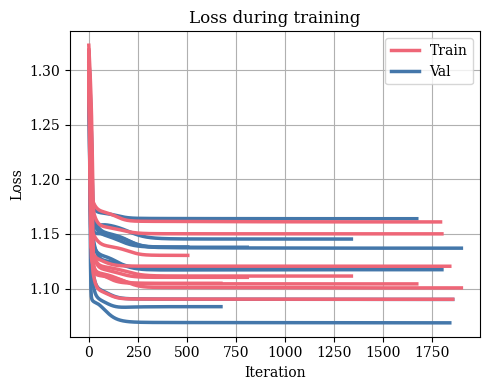

In [9]:
if LOAD_MODEL:
    models_exp = load_trained_models_list(models_exp,model_exp_folder)
    models_exp = load_model_results_list(models_exp,model_exp_folder)
    print(f"Models loaded from {model_exp_folder}")
else:
    for dt in range(data_trials):
        for mt in range(model_trials):
            print(f"Data trial: {dt+1}/{data_trials} | Model trial: {mt+1}/{model_trials}")

            tic = perf_counter()
            models_exp[dt][mt].train(train_data[dt], val_data[dt], test_data[dt])
            toc = perf_counter()
            ellapsed = toc-tic
            msg = f"{ellapsed:.1f}s" if ellapsed<60 else (f"{ellapsed//60}m {ellapsed%60:.1f}s" if ellapsed<3600 else f"{ellapsed//3600}h {(ellapsed%3600)//60}m {ellapsed%60:.2f}s")
            print(f"Time ellapsed: {msg}")
            print(f"Train loss: {models_exp[dt][mt].loss_train_pred:.3f} | " +
                f"Val loss: {models_exp[dt][mt].loss_val_pred:.3f} | " + 
                f"Test loss: {models_exp[dt][mt].loss_test_pred:.3f}" )
            print("")

    print(f"Saving experiment")
    os.makedirs(model_exp_folder, exist_ok=True)
    save_trained_models_list(models_exp,model_exp_folder)
    save_model_results_list(models_exp,model_exp_folder)
    print(f"Models saved to folder `{model_exp_folder}`")
    print("")

fig,ax = plt.subplots(figsize=(5,4)); ax.grid(1); ax.set_axisbelow(1)
for dt in range(data_trials):
    for mt in range(model_trials):
        pt, = ax.plot(models_exp[dt][mt].loss_train_list,'-',c=bq['red'], linewidth=2.5, label="Train", zorder=3)
        pv, = ax.plot(models_exp[dt][mt].loss_val_list,'-',c=bq['blue'], linewidth=2.5, label="Val", zorder=1)
ax.set_xlabel("Iteration"); ax.set_ylabel("Loss"); ax.legend(handles=[pt,pv])
ax.set_title(f"Loss during training")
fig.tight_layout()



## Visualize results

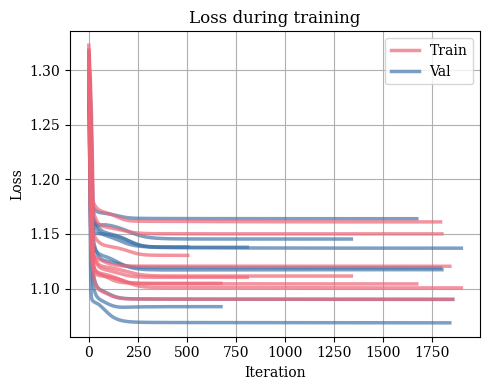

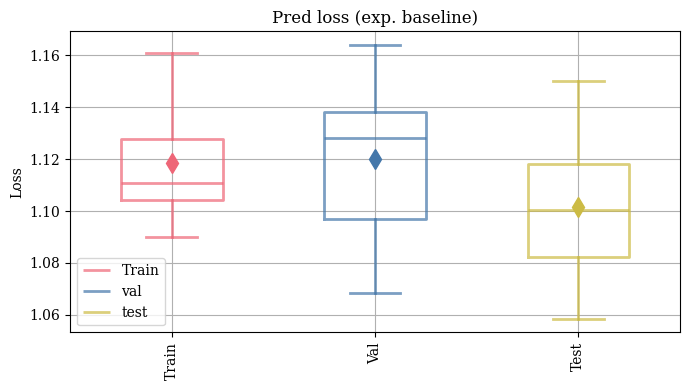

In [59]:
train_loss_pred_exp = [models_exp[dt][mt].loss_train_pred for dt in range(data_trials) for mt in range(model_trials)]
val_loss_pred_exp = [models_exp[dt][mt].loss_val_pred for dt in range(data_trials) for mt in range(model_trials)]
test_loss_pred_exp = [models_exp[dt][mt].loss_test_pred for dt in range(data_trials) for mt in range(model_trials)]

clrs = {"pi":bq['red'], "d":bq['blue'], "A":bq['yellow'], "w":bq["green"], 'l':bq['purple']}
clrs_pred = {"pi":lq['orange'], "d":lq['blue'], "A":lq['yellow'], "w":lq["pear"], 'l':lq['pink']}
cmaps ={"pi":"viridis", "d":"cividis", "A":"plasma", "w":"inferno", "l":"magma"} 
surfs = {"pi":'summer', "d":'winter', "A":'autumn', "w":'plasma', 'l':'spring'}
line_args = { "linestyle":'-', "linewidth":3, }

bp_args = {}
bp_args['train'] = boxplot_args(bq['red'])
bp_args['val'] = boxplot_args(bq['blue'])
bp_args['test'] = boxplot_args(bq['yellow'])

fig,ax = plt.subplots(figsize=(5,4)); ax.grid(1); ax.set_axisbelow(1)
for dt in range(data_trials):
    for mt in range(model_trials):
        pt, = ax.plot(models_exp[dt][mt].loss_train_list,'-',c=bq['red'], linewidth=2.5, label="Train", zorder=3, alpha=.7)
        pv, = ax.plot(models_exp[dt][mt].loss_val_list,'-',c=bq['blue'], linewidth=2.5, label="Val", zorder=1, alpha=.7)
ax.set_xlabel("Iteration"); ax.set_ylabel("Loss"); ax.legend(handles=[pt,pv])
ax.set_title(f"Loss during training")
fig.tight_layout()

fig,ax = plt.subplots(figsize=(7,4)); ax.grid(1); ax.set_axisbelow(1)
ax.boxplot( train_loss_pred_exp, positions=[0], tick_labels=['Train'], **bp_args['train'], widths=.5, label='Train' )
ax.plot( [0], [np.mean(train_loss_pred_exp)], c=bq['red'], marker='d', markersize=10, )
ax.boxplot( val_loss_pred_exp, positions=[1], tick_labels=['Val'], **bp_args['val'], widths=.5, label='val' )
ax.plot( [1], [np.mean(val_loss_pred_exp)], c=bq['blue'], marker='d', markersize=10, )
ax.boxplot( test_loss_pred_exp, positions=[2], tick_labels=['Test'], **bp_args['test'], widths=.5, label='test' )
ax.plot( [2], [np.mean(test_loss_pred_exp)], c=bq['yellow'], marker='d', markersize=10, )
ax.set_ylabel("Loss")

ax.tick_params(axis='x',rotation=90)
ax.legend()
ax.set_title("Pred loss (exp. baseline)")
fig.tight_layout()



## Visualize predictions

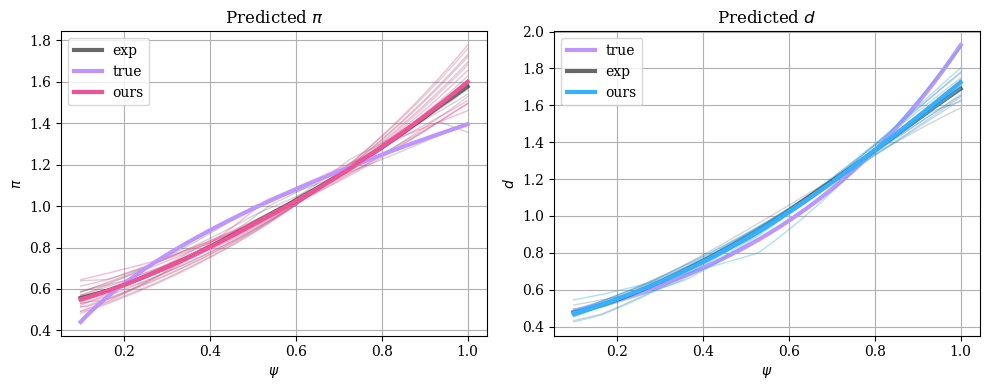

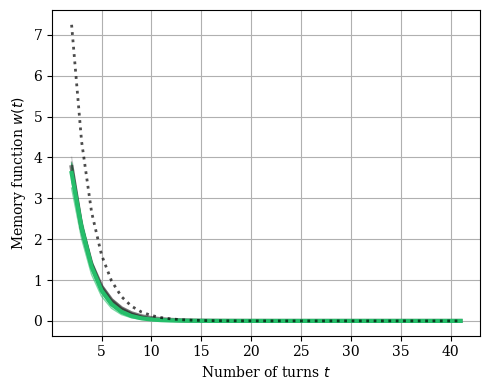

In [19]:
agg = "mean"
nrm = "mean"
scale_d = True
psi_min = .1
psi_max = 1.
num_turns = 40
d_to_pi = 1.
num_grid = 100
# ---------------------------------------

clrs = {"pi":red, "d":blue, "A":gray, "w":green, 'm':purple}
cmaps ={"pi":"viridis", "d":"cividis", "A":"plasma", "w":"inferno", "m":"magma"} 
surfs = {"pi":'summer', "d":'winter', "A":'autumn', "w":'plasma', 'm':'spring'}
line_args = { "linestyle":'-', "linewidth":3, }

agg_fn = np.mean if agg=="mean" else (np.median if agg=="median" else np.mean)
nrm_fn = np.mean if nrm=="mean" else (np.median if nrm=="median" else np.mean)

time_range = np.arange(num_turns) + 2
psi_range = np.linspace(psi_min,psi_max,num_grid)
psi_input = list(torch.FloatTensor(psi_range.reshape(-1,1)))

plot_data = Dataset([Group(psi_input)])

# ---------------------------
# Synth
complexity_pi = "complex_incr"
complexity_d = "complex_incr"

pi_true_range = generate_pis(list(torch.FloatTensor(psi_range[:,None])), complexity_pi).numpy().astype(float)
d_true_range = generate_ds(list(torch.FloatTensor(psi_range[:,None])), complexity_d).numpy().astype(float) * np.exp(1)
w_true_range = w(time_range) / np.exp(1)
w_true_max = w_true_range.max().item()

pi_true_nrm = nrm_fn(pi_true_range)
d_true_nrm = nrm_fn(d_true_range)
scale_true = d_true_nrm / d_to_pi / pi_true_nrm

m_true_range = pi_true_range + d_true_range * w_true_max
m_true_nrm = nrm_fn(m_true_range)

pi_true_range = pi_true_range / pi_true_nrm
d_true_range = d_true_range / d_true_nrm * d_to_pi
m_true_range = pi_true_range + d_true_range * scale_true * w_true_max
# ---------------------------


# ---------------------------
# Preds - ours
plot_data_preds = [[models[dt][mt].predict(plot_data) for mt in range(model_trials)] for dt in range(data_trials)]

pi_preds = [[plot_data_preds[dt][mt].pi[0].numpy().astype(float) for mt in range(model_trials)] for dt in range(data_trials)]
d_preds = [[plot_data_preds[dt][mt].d[0].numpy().astype(float) for mt in range(model_trials)] for dt in range(data_trials)]
w_preds = [[models[dt][mt].w(time_range) for mt in range(model_trials)] for dt in range(data_trials)]
w_max = [[w_preds[dt][mt].max().item() for mt in range(model_trials)] for dt in range(data_trials)]

pi_nrm = [[nrm_fn(pi_preds[dt][mt]) for mt in range(model_trials)] for dt in range(data_trials)]
d_nrm = [[nrm_fn(d_preds[dt][mt]) for mt in range(model_trials)] for dt in range(data_trials)]
scale = [[d_nrm[dt][mt] / d_to_pi / pi_nrm[dt][mt] for mt in range(model_trials)] for dt in range(data_trials)]

m_preds = [[pi_preds[dt][mt] + d_preds[dt][mt] * w_max[dt][mt] for mt in range(model_trials)] for dt in range(data_trials)]
m_nrm = [[nrm_fn(m_preds[dt][mt]) for mt in range(model_trials)] for dt in range(data_trials)]

pi_preds = [[pi_preds[dt][mt] / pi_nrm[dt][mt] for mt in range(model_trials)] for dt in range(data_trials)]
d_preds = [[d_preds[dt][mt] / d_nrm[dt][mt] * d_to_pi for mt in range(model_trials)] for dt in range(data_trials)]
m_preds = [[pi_preds[dt][mt] + d_preds[dt][mt] * scale[dt][mt] * w_max[dt][mt] for mt in range(model_trials)] for dt in range(data_trials)]

pi_range = agg_fn(sum(pi_preds,[]),axis=0)
d_range = agg_fn(sum(d_preds,[]),axis=0)
m_range = agg_fn(sum(m_preds,[]),axis=0)
# ---------------------------


# ---------------------------
# Preds - exp
plot_data_exp_preds = [[models_exp[dt][mt].predict(plot_data) for mt in range(model_trials)] for dt in range(data_trials)]

pi_exp_preds = [[plot_data_exp_preds[dt][mt].pi[0].numpy().astype(float) for mt in range(model_trials)] for dt in range(data_trials)]
d_exp_preds = [[plot_data_exp_preds[dt][mt].d[0].numpy().astype(float) for mt in range(model_trials)] for dt in range(data_trials)]
w_exp_preds = [[models_exp[dt][mt].w(time_range) for mt in range(model_trials)] for dt in range(data_trials)]
w_exp_max = [[w_exp_preds[dt][mt].max().item() for mt in range(model_trials)] for dt in range(data_trials)]

pi_exp_nrm = [[nrm_fn(pi_exp_preds[dt][mt]) for mt in range(model_trials)] for dt in range(data_trials)]
d_exp_nrm = [[nrm_fn(d_exp_preds[dt][mt]) for mt in range(model_trials)] for dt in range(data_trials)]
scale_exp = [[d_exp_nrm[dt][mt] / d_to_pi / pi_exp_nrm[dt][mt] for mt in range(model_trials)] for dt in range(data_trials)]

m_exp_preds = [[pi_exp_preds[dt][mt] + d_exp_preds[dt][mt] * w_exp_max[dt][mt] for mt in range(model_trials)] for dt in range(data_trials)]
m_exp_nrm = [[nrm_fn(m_exp_preds[dt][mt]) for mt in range(model_trials)] for dt in range(data_trials)]

pi_exp_preds = [[pi_exp_preds[dt][mt] / pi_exp_nrm[dt][mt] for mt in range(model_trials)] for dt in range(data_trials)]
d_exp_preds = [[d_exp_preds[dt][mt] / d_exp_nrm[dt][mt] * d_to_pi for mt in range(model_trials)] for dt in range(data_trials)]
m_exp_preds = [[pi_exp_preds[dt][mt] + d_exp_preds[dt][mt] * scale_exp[dt][mt] * w_exp_max[dt][mt] for mt in range(model_trials)] for dt in range(data_trials)]

pi_exp_range = agg_fn(sum(pi_exp_preds,[]),axis=0)
d_exp_range = agg_fn(sum(d_exp_preds,[]),axis=0)
m_exp_range = agg_fn(sum(m_exp_preds,[]),axis=0)
# ---------------------------


# ---------------------------
# pi and d
fig,axes = plt.subplots(1,2,figsize=(2*fw,fl)); _ = [a.grid(1) for a in axes]
ax = axes[0]
for dt in range(data_trials):
    for mt in range(model_trials):
        ax.plot(psi_range,pi_exp_preds[dt][mt], c=black, linestyle='-', linewidth=1, alpha=.2)
ax.plot(psi_range, pi_exp_range, c=black, **line_args, label="exp", alpha=.7)
for dt in range(data_trials):
    for mt in range(model_trials):
        ax.plot(psi_range,pi_preds[dt][mt], c=clrs['pi'], linestyle='-', linewidth=1, alpha=.4)
ax.plot(psi_range, pi_true_range, c=mauve, linestyle='-', linewidth=3, label="true")
ax.plot(psi_range, pi_range, c=clrs['pi'], **line_args, label="ours")
ax.set_xlabel(r"$\psi$"); ax.set_ylabel(r"$\pi$"); ax.set_title(r"Predicted $\pi$"); ax.legend()
ax = axes[1]
for dt in range(data_trials):
    for mt in range(model_trials):
        ax.plot(psi_range,d_exp_preds[dt][mt], c=black, linestyle='-', linewidth=1, alpha=.2)
ax.plot(psi_range, d_true_range, c=mauve, linestyle='-', linewidth=3, label="true")
ax.plot(psi_range, d_exp_range, c=black, **line_args, label="exp", alpha=.7)
for dt in range(data_trials):
    for mt in range(model_trials):
        ax.plot(psi_range,d_preds[dt][mt], c=clrs['d'], linestyle='-', linewidth=1, alpha=.4)
ax.plot(psi_range, d_range, c=clrs['d'], **line_args, label="ours")
ax.set_xlabel(r"$\psi$"); ax.set_ylabel(r"$d$"); ax.set_title(r"Predicted $d$"); ax.legend()
fig.tight_layout()
# ---------------------------

w_exp_preds = [[w_exp_preds[dt][mt] * scale_exp[dt][mt] for mt in range(model_trials)] for dt in range(data_trials)]
w_exp_max = [[w_exp_max[dt][mt] * scale_exp[dt][mt] for mt in range(model_trials)] for dt in range(data_trials)]
# w_range = agg_fn(sum(w_exp_preds,[]),axis=0)
w_exp_range = agg_fn([w_exp_preds[dt][0] for dt in range(data_trials) if dt not in [0,5,9]],axis=0)

w_preds = [[w_preds[dt][mt] * scale[dt][mt] for mt in range(model_trials)] for dt in range(data_trials)]
w_max = [[w_max[dt][mt] * scale[dt][mt] for mt in range(model_trials)] for dt in range(data_trials)]
# w_range = agg_fn(sum(w_preds,[]),axis=0)
w_range = agg_fn([w_preds[dt][0] for dt in range(data_trials) if dt not in [0,5,9]],axis=0)

# w_true_range = w(time_range)
# # w_true_range = w(time_range) * agg_fn(sum(scale,[]))
# scale_true = agg_fn(sum(w_max,[]))
# w_true_range = w_true_range / w_true_range.max() * scale_true
w_true_range = w_true_range * scale_true
w_true_max = w_true_max * scale_true

fig,ax = plt.subplots(figsize=(fw,fl)); ax.grid(1)
for dt in range(data_trials):
    if dt in [0,5,9]:
        continue
    for mt in range(model_trials):
        ax.plot(time_range, w_exp_preds[dt][mt], '-', c=black, linewidth=1, alpha=.2)
        ax.plot(time_range, w_preds[dt][mt], '-', c=clrs['w'], linewidth=1, alpha=.6)
ax.plot(time_range, w_exp_range, '-', c=black, linewidth=3, alpha=.6)
ax.plot(time_range, w_range, '-', c=clrs['w'], linewidth=3, alpha=1)
ax.plot(time_range, w_true_range, ':', c='k', linewidth=2, zorder=5, alpha=.7, label="True")
ax.set_xlabel(r"Number of turns $t$"); ax.set_ylabel(r"Memory function $w(t)$")
fig.tight_layout()

df_data = np.array([time_range, w_true_range, w_range,w_exp_range] + [w_preds[dt][0].numpy().astype(float) for dt in range(data_trials)] + [w_exp_preds[dt][0] for dt in range(data_trials)]).T
df_cols = ['turns','w_true','w_pred_avg','w_exp_avg'] + [f"w_pred_{dt}" for dt in range(data_trials)] + [f"w_exp_pred_{dt}" for dt in range(data_trials)]
pd.DataFrame(data=df_data,columns=df_cols).to_csv("synth_exp_memfunc_2025-09-08.csv", index=False, header=True)



## Visualize loss results

In [ ]:
print("True")
test_loss_true = [compute_loss(test_data[dt]).item() for dt in range(data_trials)]
# test_loss_true_tt = [compute_loss(test_data[dt],weight_func=get_turn_type_weights).item() for dt in range(data_trials)]
test_loss_true_tta = [compute_loss(test_data[dt],weight_func=get_turn_type_agg_weights).item() for dt in range(data_trials)]


print("Turn type agg loss")
for dt in range(data_trials):
    for mt in range(model_trials):
        models[dt][mt].weight_func = get_turn_type_agg_weights
        models_exp[dt][mt].weight_func = get_turn_type_agg_weights

test_loss_pred_tta = [models[dt][mt].test(test_data[dt])[0] for dt in range(data_trials) for mt in range(model_trials)]
test_loss_pred_tta_exp = [models_exp[dt][mt].test(test_data[dt])[0] for dt in range(data_trials) for mt in range(model_trials)]


print("Original loss")
for dt in range(data_trials):
    for mt in range(model_trials):
        models[dt][mt].weight_func = None
        models_exp[dt][mt].weight_func = None

test_loss_pred = [models[dt][mt].test(test_data[dt])[0] for dt in range(data_trials) for mt in range(model_trials)]
test_loss_pred_exp = [models_exp[dt][mt].test(test_data[dt])[0] for dt in range(data_trials) for mt in range(model_trials)]


print(f"No memory")
num_feat = test_data[0].num_feat
psis_same = [[list(torch.ones((test_data[dt].num_speakers[g], num_feat))) for g in range(test_data[dt].num_groups)] for dt in range(data_trials)]
convos = [test_data[dt].convos for dt in range(data_trials)]
pis_same = [[torch.ones(test_data[dt].num_speakers[g]) for g in range(test_data[dt].num_groups)] for dt in range(data_trials)]
ds_same = [[torch.zeros(test_data[dt].num_speakers[g]) for g in range(test_data[dt].num_groups)] for dt in range(data_trials)]
samenomem_test_data = Datasets_from_lists(psis_same, pi_tris=pis_same, d_tris=ds_same, convo_tris=convos)

samenomem_loss_pred = [compute_loss(samenomem_test_data[dt]).item() for dt in range(data_trials)]
samenomem_loss_pred_tta = [compute_loss(samenomem_test_data[dt],weight_func=get_turn_type_agg_weights).item() for dt in range(data_trials)]


print(f"Only memory")
convos = [test_data[dt].convos for dt in range(data_trials)]
pis_same = [[1e-2 * torch.ones(test_data[dt].num_speakers[g]) for g in range(test_data[dt].num_groups)] for dt in range(data_trials)]
ds_same = [[torch.ones(test_data[dt].num_speakers[g]) for g in range(test_data[dt].num_groups)] for dt in range(data_trials)]
onlymem_test_data = Datasets_from_lists(psis_same, pi_tris=pis_same, d_tris=ds_same, convo_tris=convos)

onlymem_loss_pred = [compute_loss(onlymem_test_data[dt]).item() for dt in range(data_trials)]
onlymem_loss_pred_tta = [compute_loss(onlymem_test_data[dt],weight_func=get_turn_type_agg_weights).item() for dt in range(data_trials)]


True
Turn type agg loss
Original loss
No memory
Only memory


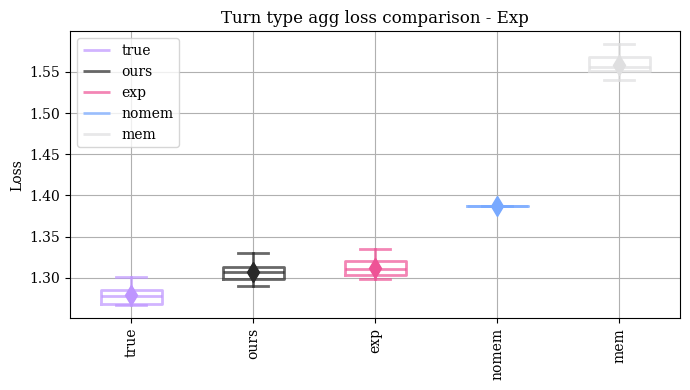

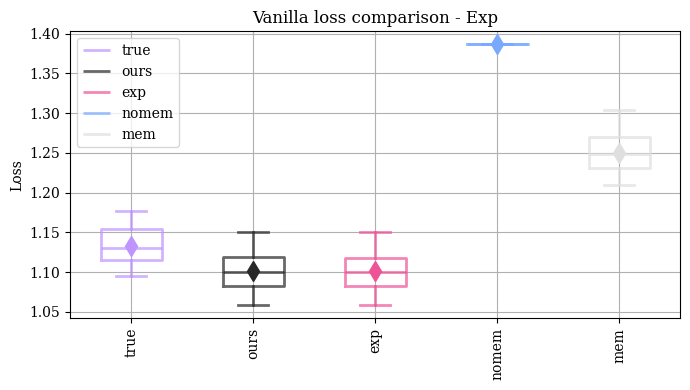

In [ ]:
black = "#282828"
red = "#ee5396"
green = "#25be6a"
cyan = "#08bdba"
purple = "#78a9ff"
mauve = "#be95ff"
blue = "#33b1ff"
gray = "#dfdfe0"


clrs_dct = {
    'true': mauve,
    'ours': black,
    'exp': red,
    'nomem': purple,
    'mem': gray,
}
labs = list(clrs_dct.keys())
bp_args = {k:boxplot_args(clrs_dct[k]) for k in labs}

test_losses_dct = {
    'true': test_loss_true_tta,
    'ours': test_loss_pred_tta,
    'exp': test_loss_pred_tta_exp,
    'nomem': samenomem_loss_pred_tta,
    'mem': onlymem_loss_pred_tta,
}

fig,ax = plt.subplots(figsize=(7,4)); ax.grid(1); ax.set_axisbelow(1)
for i in range(len(labs)):
    ax.boxplot( test_losses_dct[labs[i]], positions=[i], tick_labels=[labs[i]], **bp_args[labs[i]], widths=.5, label=labs[i] )
    ax.plot( [i], [np.mean(test_losses_dct[labs[i]])], c=clrs_dct[labs[i]], marker='d', markersize=10, )

ax.set_ylabel("Loss"); ax.tick_params(axis='x',rotation=90); ax.legend()
ax.set_title("Turn type agg loss comparison - Exp")
fig.tight_layout()


test_losses_dct = {
    'true': test_loss_true,
    'ours': test_loss_pred,
    'exp': test_loss_pred_exp,
    'nomem': samenomem_loss_pred,
    'mem': onlymem_loss_pred,
}

fig,ax = plt.subplots(figsize=(7,4)); ax.grid(1); ax.set_axisbelow(1)
for i in range(len(labs)):
    ax.boxplot( test_losses_dct[labs[i]], positions=[i], tick_labels=[labs[i]], **bp_args[labs[i]], widths=.5, label=labs[i] )
    ax.plot( [i], [np.mean(test_losses_dct[labs[i]])], c=clrs_dct[labs[i]], marker='d', markersize=10, )

ax.set_ylabel("Loss"); ax.tick_params(axis='x',rotation=90); ax.legend()
ax.set_title("Vanilla loss comparison - Exp")
fig.tight_layout()

df_data = np.array([test_loss_true_tta,test_loss_pred_tta,test_loss_pred_tta_exp,samenomem_loss_pred_tta,onlymem_loss_pred_tta]).T
df_cols = ['true_exp','ours_exp','exp_exp','nomem_exp','mem_exp']
pd.DataFrame(data=df_data, columns=df_cols)
pd.DataFrame(data=df_data, columns=df_cols).to_csv("synth_exp_turntype_boxplots_2025-09-08.csv", index=False, header=True)

df_data = np.array([test_loss_true,test_loss_pred,test_loss_pred_exp,samenomem_loss_pred,onlymem_loss_pred]).T
df_cols = ['true_exp','ours_exp','exp_exp','nomem_exp','mem_exp']
pd.DataFrame(data=df_data, columns=df_cols).to_csv("synth_exp_vanilla_boxplots_2025-09-08.csv", index=False, header=True)
